# 0 Imports

In [1]:
from datetime import datetime
from enum import Enum
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, hamming_loss, precision_score, recall_score, f1_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain

import nltk

from wordcloud import WordCloud

import scripts

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

np.random.seed(0)


***
# 1 Config

In [49]:
config = {
    "bag": False,
    "tfidf": False,
    "unsupervised": True,
    "supervised": {
        "knc": False, # must be False, too greedy
        "dtc": False, # should be False, long run
        "rfc": False, # must be False, too long
        "sgd": True, # should be True
        "lgc": True # should be True
    }
}

***
# 2 Data Loading

In [3]:
data = pd.read_csv("data/data_cleaned.csv", index_col="Id")

data["Tags"] = data["Tags"].apply(eval)
# data["Tokens"] = data["Tokens"].apply(eval)
# data["POS"] = data["POS"].apply(eval)
# data["Lemmatized"] = data["Lemmatized"].apply(eval)
# data["LemmaAndStem"] = data["LemmaAndStem"].apply(eval)

In [4]:
data.head()

,Title,Body,Tags,Tokens,POS,Lemmatized,LemmaAndStem,Sentence
Id,,,,,,,,
4,how to convert a decimal to a double in c#?,i want to use a to change a 's opacity.\nthis is my code:\n\nwhen i build the application it gives the following error:\n\n\n\ni have tried using and but then the doesn't work. this code worked fine in a past vb.net project.\n,"[c#, floating-point, type-conversion, double, decimal]","['want', 'use', 'change', 'opacity', 'code', 'build', 'application', 'gives', 'following', 'error', 'tried', 'using', 'work', 'code', 'worked', 'fine', 'past', 'vb', '.net', 'project', 'convert', 'decimal', 'double', 'c#']","[('want', 'n'), ('use', 'n'), ('change', 'n'), ('opacity', 'n'), ('code', 'n'), ('build', 'a'), ('application', 'n'), ('gives', 'v'), ('following', 'v'), ('error', 'n'), ('tried', 'v'), ('using', 'v'), ('work', 'n'), ('code', 'n'), ('worked', 'v'), ('fine', 'a'), ('past', 'n'), ('vb', 'a'), ('.net', 'n'), ('project', 'n'), ('convert', 'v'), ('decimal', 'a'), ('double', 'a'), ('c#', 'n')]","['want', 'use', 'change', 'opacity', 'code', 'build', 'application', 'give', 'follow', 'error', 'try', 'use', 'work', 'code', 'work', 'fine', 'past', 'vb', '.net', 'project', 'convert', 'decimal', 'double', 'c#']","['want', 'use', 'chang', 'opac', 'code', 'build', 'applic', 'give', 'follow', 'error', 'tri', 'use', 'work', 'code', 'work', 'fine', 'past', 'vb', '.net', 'project', 'convert', 'decim', 'doubl', 'c#']",want use chang opac code build applic give follow error tri use work code work fine past vb .net project convert decim doubl c#
6,why did the width collapse in the percentage width child element in an absolutely positioned parent on internet explorer 7?,i have an absolutely positioned containing several children one of which is a relatively positioned . when i use a on the child it collapses to on ie7 but not on firefox or safari.\nif i use it works. if the parent is relatively positioned the percentage width on the child works.\n\nis there something i'm missing here?\nis there an easy fix for this besides the on the child?\nis there an area of the css specification that covers this?\n\n,"[html, css, internet-explorer-7]","['absolutely', 'positioned', 'containing', 'several', 'children', 'one', 'relatively', 'positioned', 'use', 'child', 'collapses', 'ie', 'firefox', 'safari', 'use', 'works', 'parent', 'relatively', 'positioned', 'percentage', 'width', 'child', 'works', 'something', 'missing', 'easy', 'fix', 'besides', 'child', 'area', 'css', 'specification', 'covers', 'width', 'collapse', 'percentage', 'width', 'child', 'element', 'absolutely', 'positioned', 'parent', 'internet', 'explorer']","[('absolutely', 'r'), ('positioned', 'v'), ('containing', 'v'), ('several', 'a'), ('children', 'n'), ('one', 'n'), ('relatively', 'r'), ('positioned', 'v'), ('use', 'n'), ('child', 'n'), ('collapses', 'n'), ('ie', 'v'), ('firefox', 'n'), ('safari', 'n'), ('use', 'n'), ('works', 'v'), ('parent', 'n'), ('relatively', 'r'), ('positioned', 'v'), ('percentage', 'n'), ('width', 'n'), ('child', 'n'), ('works', 'v'), ('something', 'n'), ('missing', 'v'), ('easy', 'a'), ('fix', 'a'), ('besides', 'n'), ('child', 'a'), ('area', 'n'), ('css', 'n'), ('specification', 'n'), ('covers', 'v'), ('width', 'a'), ('collapse', 'n'), ('percentage', 'n'), ('width', 'n'), ('child', 'n'), ('element', 'n'), ('absolutely', 'r'), ('positioned', 'v'), ('parent', 'a'), ('internet', 'n'), ('explorer', 'n')]","['absolutely', 'position', 'contain', 'several', 'child', 'one', 'relatively', 'position', 'use', 'child', 'collapse', 'ie', 'firefox', 'safari', 'use', 'work', 'parent', 'relatively', 'position', 'percentage', 'width', 'child', 'work', 'something', 'miss', 'easy', 'fix', 'besides', 'child', 'area', 'cs', 'specification', 'cover', 'width', 'collapse', 'percentage', 'width', 'child', 'element', 'absolutely', 'position', 'parent', 'internet', 'explorer']","['absolut', 'posit', 'contain', 'sever', 'children', 'one', 'relat', 'posit', 'use', 'child', 'colla

***
# 3 Tags

In [5]:
data[["Tags"]].head()

,Tags
Id,
4,"[c#, floating-point, type-conversion, double, decimal]"
6,"[html, css, internet-explorer-7]"
9,"[c#, .net, datetime]"
11,"[c#, datetime, time, datediff, relative-time-span]"
13,"[html, browser, timezone, user-agent, timezone-offset]"


In [6]:
data.Tags.values

array([list(['c#', 'floating-point', 'type-conversion', 'double', 'decimal']),
       list(['html', 'css', 'internet-explorer-7']),
       list(['c#', '.net', 'datetime']), ...,
       list(['css', 'xhtml', 'refactoring']),
       list(['python', 'class', 'anonymous-class']),
       list(['c', 'linux', 'file', 'io', 'std'])], dtype=object)

In [7]:
tags = []
for row in data.Tags.values:
    tags += row
tags_df = pd.DataFrame(data=tags, columns=["Tag"]).value_counts().reset_index()
tags_df.columns = ["Tag", "Count"]

In [8]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9252 entries, 0 to 9251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     9252 non-null   object
 1   Count   9252 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 144.7+ KB


In [9]:
tags_df.head()

,Tag,Count
0,c#,6448
1,.net,5174
2,java,3758
3,asp.net,3261
4,c++,2691


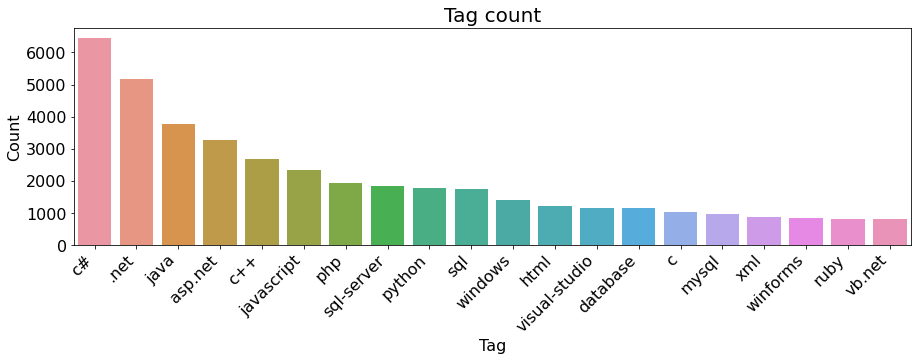

In [10]:
plt.figure(figsize=(15, 4))

sns.barplot(data=tags_df.iloc[:20], x="Tag", y="Count")

plt.title("Tag count", size=20)
plt.xlabel("Tag", size=16)
plt.ylabel("Count", size=16)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

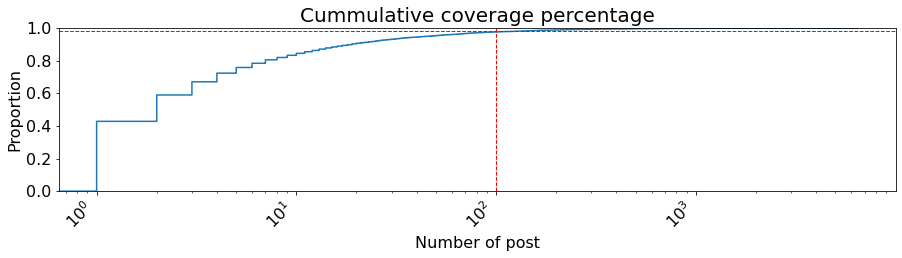

In [11]:
plt.figure(figsize=(15, 3))

ax = sns.ecdfplot(data=tags_df, x="Count", log_scale=True)

plt.axhline(0.98, linestyle="--", linewidth=1, color="r")
plt.axvline(100, linestyle="--", linewidth=1, color="r")

plt.title("Cummulative coverage percentage", size=20)
plt.xlabel("Number of post", size=16)
plt.ylabel("Proportion", size=16)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

In [12]:
tags_df = tags_df[:100]
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     100 non-null    object
 1   Count   100 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


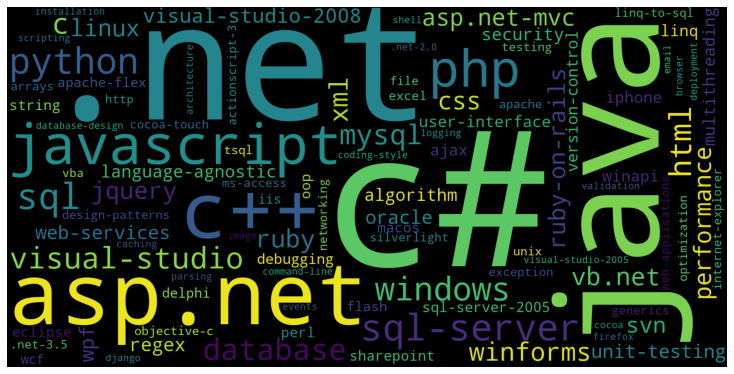

In [13]:
word_frequencies = dict(zip(tags_df.Tag, tags_df.Count))
wordcloud = WordCloud(background_color="black", width=1600, height=800).generate_from_frequencies(word_frequencies)

fig = plt.figure(figsize=(15, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [14]:
tags = tags_df.Tag.tolist()

In [15]:
tags[:20]

['c#',
 '.net',
 'java',
 'asp.net',
 'c++',
 'javascript',
 'php',
 'sql-server',
 'python',
 'sql',
 'windows',
 'html',
 'visual-studio',
 'database',
 'c',
 'mysql',
 'xml',
 'winforms',
 'ruby',
 'vb.net']

In [16]:
def find_or_remove(cell, word_list):
    return [word for word in cell if word in word_list]


In [17]:
data["Tags_Reduced"] = data.apply(lambda row: find_or_remove(row["Tags"], tags),axis="columns")

In [18]:
data["Tags_Reduced"].isna().any()

False

***
# 4 Bag-Of-Words

In [19]:
def bow(dataset, max_features=None, min_df=0.0, max_df=1.0):
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features=max_features, max_df=max_df, min_df=min_df)
    matrix = vectorizer.fit_transform(dataset)

    data_dense = matrix.todense()
    print(f"Sparcity: {((data_dense > 0).sum() / data_dense.size)*100:.4}%")

    vocab = vectorizer.get_feature_names_out()

    matrix = matrix.toarray()
    bag = pd.DataFrame(data=matrix, columns=vocab)
    return bag

In [20]:
display = None
if config["bag"]:
    bag = bow(data, "Sentence")
    display = bag.iloc[:5, :20]
display

***
# 5 TF-IDF

In [21]:
def tfidf(dataset, max_features=None, min_df=0.0, max_df=1.0):
    vectorizer = TfidfVectorizer(tokenizer=None, stop_words=None, max_features=max_features, min_df=min_df, max_df=max_df)
    matrix = vectorizer.fit_transform(dataset).toarray()
    vocab = vectorizer.get_feature_names_out()
    tfidf = pd.DataFrame(data=matrix, columns=vocab)
    return tfidf

In [22]:
display = None
if config["tfidf"]:
    tfidf = tfidf(data, "Sentence")
    display = tfidf.iloc[:5, :20]
display

***
# 6 Unsupervised

## 6.0 Utils

In [23]:
def latent_dirichlet_allocation(dataset: pd.DataFrame, n_topics: int, max_iter=5, learning_offset=50, max_features=None):
    feature_names = dataset.columns

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter, learning_method="online", learning_offset=learning_offset, random_state=0)
    lda.fit(data)
    return lda, feature_names

In [24]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn
#
def latent_dirichlet_allocation_tuning(dataset: pd.DataFrame, param_grid: dict):
    data_bow = bow(dataset, min_df=.005)
    feature_names = data_bow.columns

    lda = LatentDirichletAllocation()
    gs = GridSearchCV(lda, param_grid)
    gs.fit(data_bow)

    return gs, feature_names, data_bow

In [25]:
def get_dominant_topic(lda_model, data_bow, dataset_row_nb):
    lda_output = lda_model.transform(data_bow)

    topic_names = ["Topic"+str(i) for i in range(lda_model.n_components)]
    doc_names = ["Doc"+str(i) for i in range(dataset_row_nb)]

    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

    dominant_topics = np.argmax(df_document_topic.values, axis=1)
    df_document_topic["Dominant_Topic"] = dominant_topics

    return df_document_topic

In [26]:
def topic_distribution(dominant_topic_df):
    distribution = dominant_topic_df["Dominant_Topic"].value_counts().reset_index()
    distribution.columns = ["Dominant_Topic", "Count"]

    plt.figure(figsize=(15, 4))

    sns.countplot(data=dominant_topic_df, x="Dominant_Topic")

    plt.title("Tag count", size=20)
    plt.xlabel("Tag", size=16)
    plt.ylabel("Count", size=16)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.show()

    return distribution

In [27]:
def topic_words(lda_model, feature_names, n_words=20):
    keywords = np.array(feature_names)
    topic_keywords = []
    for topic_weight in lda_model.components_:
        topic_keyword_locs = (-topic_weight).argsort()[:n_words]
        topic_keywords.append(feature_names.take(topic_keyword_locs))
    
    topic_keywords_df = pd.DataFrame(data=topic_keywords)
    topic_keywords_df.columns = ["Word"+str(i) for i in range(topic_keywords_df.shape[1])]
    topic_keywords_df.index = ["Topic"+str(i) for i in range(topic_keywords_df.shape[0])]
    return topic_keywords_df

In [28]:
def make_prediction(lda_model, sentence, topic_keywords_dataset):
    sentence = scripts.preprocess_sentence(sentence)
    data_bow = bow([sentence], min_df=.005)
    topic_probability_score = lda_model.transform(sentence)
    topic = topic_keywords_dataset.iloc[np.argmax(topic_probability_score), :].values.tolist()
    return topic, topic_probability_score

***
## 6.1 Latent Dirichlet Allocation

In [29]:
if config["unsupervised"]:
    param_grid = {
        "n_components": [10],
        "learning_decay": [.7],
        "random_state": [0],
        "n_jobs": [10]
    }

    gs, feature_names, data_bow = latent_dirichlet_allocation_tuning(data["Sentence"], param_grid)

Sparcity: 2.713%


In [30]:
print(f"Log likelihood: {gs.best_estimator_.score(data_bow)}")
print(f"Perplexity: {gs.best_estimator_.perplexity(data_bow)}")
print(f"Best params: {gs.best_params_}")

Log likelihood: -14346463.94069532
Perplexity: 623.6672364978546
Best params: {'learning_decay': 0.7, 'n_components': 10, 'n_jobs': 10, 'random_state': 0}


In [31]:
dominant_topic_df = get_dominant_topic(gs.best_estimator_, data_bow, data.shape[0])
dominant_topic_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Dominant_Topic
Doc0,0.00,0.00,0.23,0.00,0.00,0.10,0.00,0.64,0.00,0.00,7
Doc1,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,6
Doc2,0.01,0.65,0.01,0.01,0.01,0.01,0.01,0.01,0.28,0.01,1
Doc3,0.01,0.19,0.01,0.01,0.01,0.01,0.01,0.01,0.76,0.01,8
Doc4,0.48,0.01,0.01,0.01,0.01,0.47,0.01,0.01,0.01,0.01,0


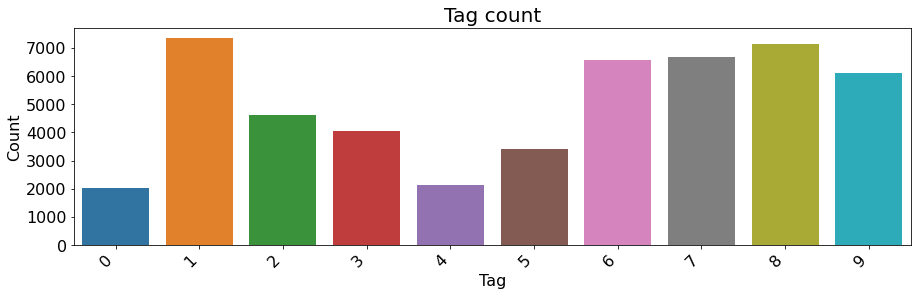

,Dominant_Topic,Count
0,1,7350
1,8,7131
2,7,6658
3,6,6551
4,9,6100
5,2,4611
6,3,4047
7,5,3416
8,4,2115
9,0,2021


In [32]:
topic_distribution(dominant_topic_df)

In [33]:
topic_keywords_df = pd.DataFrame(data=gs.best_estimator_.components_, columns=feature_names, index=dominant_topic_df.columns[:-1])
topic_keywords_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Topic0 to Topic9
Columns: 1234 entries, abil to zip
dtypes: float64(1234)
memory usage: 96.5+ KB


In [34]:
topic_keywords_df.iloc[:, :20]

,abil,abl,absolut,abstract,accept,access,accomplish,accord,account,achiev,across,act,action,actionscript,activ,actual,ad,add,addit,address
Topic0,59.012833,487.021512,14.340853,0.100013,104.845596,1274.725120,46.517025,10.697793,1088.609257,67.439374,39.376426,22.136755,155.279515,0.142020,609.680457,78.378223,269.947067,149.020112,80.706348,357.774940
Topic1,5.356354,490.288176,10.371396,44.091733,129.451630,762.360899,135.510919,93.900759,25.549119,141.250988,120.384425,39.222207,30.492898,0.376709,33.463655,467.361034,531.362996,765.613837,218.977697,276.598813
Topic2,25.432957,560.434674,39.031989,229.371209,78.212609,727.280524,35.420630,91.053079,0.100008,124.169837,120.755410,23.204136,52.283053,53.435926,8.759393,270.901821,720.962400,1448.601471,157.915765,0.330803
Topic3,39.319929,591.826040,8.359320,0.100015,57.151476,1438.252180,54.804364,26.918615,68.125129,24.609088,88.928444,27.018284,20.360347,3.914867,82.535147,92.758030,86.311387,146.063556,61.897443,271.268306
Topic4,0.653590,109.476248,14.868041,0.100018,5.857907,37.082468,0.103757,34.837971,0.100238,5.097735,47.354552,6.773256,7.731103,0.100012,148.571361,144.765215,130.513402,87.654621,45.480714,14.389942
Topic5,0.673900,257.891585,14.489036,0.951138,114.097598,797.170549,31.161157,66.219278,0.417712,47.065885,61.737930,19.911157,335.563512,6.185984,13.191611,149.586714,288.377483,258.816030,76.039288,548.729284
Topic6,72.715945,756.610017,120.125710,0.176062,75.801576,174.508262,115.931219,72.570275,0.102739,219.562668,109.967947,59.302044,469.303634,93.520417,141.467981,307.856456,679.695110,1176.722852,116.364609,37.670717
Topic7,0.125269,513.854302,74.549360,3.628605,319.748317,210.265815,88.848501,80.593918,0.243312,85.653155,77.417208,12.299352,102.230190,48.773937,13.955395,515.931495,223.753088,238.585286,44.154824,57.432575
Topic8,204.854902,556.090658,64.981761,62.141934,196.496569,77.443815,60.637884,49.037747,1.231582,30.445517,364.929892,70.696890,89.804841,0.100025,69.872107,751.030192,300.243616,446.189301,194.395125,115.382942
Topic9,87.854320,496.506788,45.882534,224.339274,131.336722,423.910369,95.064543,10.170565,0.520905,131.705754,180.147765,16.435919,28.950909,106.450103,32.502893,395.430819,111.833451,160.732934,80.068185,24.421679


In [35]:
topic_keywords_dataset = topic_words(lda_model=gs.best_estimator_, feature_names=feature_names, n_words=20)
topic_keywords_dataset

,Word0,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15,Word16,Word17,Word18,Word19
Topic0,user,applic,use,window,site,log,way,session,would,password,access,authent,secur,want,domain,account,need,login,app,email
Topic1,tabl,use,data,valu,way,queri,databas,sql,like,object,column,would,store,one,list,need,row,want,field,number
Topic2,file,class,use,project,xml,creat,way,object,properti,like,folder,want,directori,build,need,dll,type,librari,one,would
Topic3,server,use,instal,sql,run,databas,connect,window,machin,applic,file,work,client,need,way,get,local,access,script,develop
Topic4,visual,studio,report,run,use,time,log,debug,error,problem,process,build,cach,get,vs,file,version,search,start,applic
Topic5,net,web,asp,servic,use,http,com,request,applic,get,page,server,url,client,messag,call,mvc,work,error,system
Topic6,page,control,use,form,imag,work,way,html,display,like,click,want,javascript,event,button,text,window,get,set,select
Topic7,use,code,file,get,error,string,tri,line,function,call,like,work,method,follow,way,command,return,want,except,would
Topic8,use,would,like,work,one,look,code,question,good,know,project,develop,time,thing,think,realli,need,someth,make,get
Topic9,use,test,code,java,applic,would,like,program,thread,languag,method,way,write,unit,function,framework,know,class,implement,need


In [44]:
sentence = "<p>I want to create a sql script to<code>something</code> automatise the data seeding</p>"

In [48]:
make_prediction(lda_model=gs.best_estimator_, sentence=sentence, topic_keywords_dataset=topic_keywords_dataset)

Sparcity: 100.0%


/opt/anaconda/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got scalar array instead:
array=want creat sql script automatis data seed.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

***
# 7 Supervised

## 7.0 Utils

In [51]:
# https://www.codementor.io/@agarrahul01/multiclass-classification-using-random-forest-on-scikit-learn-library-hkk4lwawu
# https://www.kaggle.com/patrickaudriaz/random-forests-for-multiclass-classification
# 
def classifier_tuning(dataset: pd.DataFrame, meta_model, model, param_grid: dict, scoring: str = "f1_micro"):
    start = datetime.now()

    X = tfidf(dataset["Sentence"], min_df=.005, max_df=1.0)

    # target multi label binarizer
    multi_label_binarizer = MultiLabelBinarizer()
    y = multi_label_binarizer.fit_transform(dataset["Tags_Reduced"])

    feature_names = X.columns
    classes = multi_label_binarizer.classes_

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

    # multioutput or onevsrest ...
    meta_model.fit(X_train, y_train)

    # gridsearch tuning/fitting
    gs = GridSearchCV(meta_model, param_grid, scoring=scoring, refit=True)
    gs.fit(X_train, y_train)

    # advanced evaluation
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"classifier_tuning > Time taken to run this cell : {datetime.now() - start} \n")

    return gs, classes, y_test, y_pred

In [52]:
def evaluate(gs, classes, y_test, y_pred):
    start = datetime.now()

    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Hamming loss ", hamming_loss(y_test, y_pred))

    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print("Macro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

    print(f"evaluate > Time taken to run this cell : {datetime.now() - start}\n")

***
## 7.1 K Neighbors Classifier with MultiOutput Classifier

too greedy...

In [ ]:
if config["supervised"]["knc"]:
    param_grid = {
        "estimator__n_neighbors": [5],
        "estimator__n_jobs": [10],
        "n_jobs": [10]
    }

    meta_model = MultiOutputClassifier
    model = KNeighborsClassifier()
    gs, classes, y_test, y_pred = classifier_tuning(data, meta_model, model, param_grid)
    evaluate(gs, classes, y_test, y_pred)

***
## 7.2 Decision Tree Classifier with MultiOutput Classifier

In [ ]:
if config["supervised"]["dtc"]:
    param_grid = {
        "estimator__max_depth": [50],
        "estimator__criterion": ["entropy"],
        "estimator__random_state": [0],
        "n_jobs": [10]
    }

    meta_model = MultiOutputClassifier
    model = DecisionTreeClassifier()
    gs, classes, y_test, y_pred = classifier_tuning(data, meta_model, model, param_grid)
    evaluate(gs, classes, y_test, y_pred)

***
## 7.3 Random Forest Classifier with MultiOutput Classifier

too long...

In [ ]:
if config["supervised"]["rfc"]:
    param_grid = {
        "estimator__n_estimators": [100],
        "estimator__max_depth": [50],
        "estimator__criterion": ["entropy"],
        "estimator__n_jobs": [10],
        "estimator__random_state": [0],
        "n_jobs": [10]
    }

    meta_model = MultiOutputClassifier
    model = RandomForestClassifier()
    gs, classes, y_test, y_pred = classifier_tuning(data, meta_model, model, param_grid)
    evaluate(gs, classes, y_test, y_pred)

***
## 7.4 SGD  with OneVsRest Classifier

In [ ]:
if config["supervised"]["sgd"]:
    param_grid = {
        "estimator__loss": ["log"],
        "estimator__alpha": [0.00001],
        "estimator__penalty": ["l1"],
        "estimator__n_jobs": [10],
        "estimator__random_state": [0],
        "n_jobs": [10]
    }

    model = SGDClassifier()
    meta_model = OneVsRestClassifier(model)
    gs, classes, y_test, y_pred = classifier_tuning(data, meta_model, model, param_grid)
    evaluate(gs, classes, y_test, y_pred)

***
## 7.5 Logistic Regression with OneVsRest Classifier

In [ ]:
if config["supervised"]["lgc"]:
    param_grid = {
        "estimator__solver": ["liblinear"],
        "estimator__penalty": ["l1"],
        "estimator__random_state": [0],
        "n_jobs": [10]
    }

    model = LogisticRegression()
    meta_model = OneVsRestClassifier(model)
    gs, classes, y_test, y_pred = classifier_tuning(data, meta_model, model, param_grid)
    evaluate(gs, classes, y_test, y_pred)

In [ ]:
if config["supervised"]["lgc"]:
    param_grid = {
        "classifier__solver": ["liblinear"],
        "classifier__penalty": ["l1"],
        "classifier__random_state": [0],
        # "classifier__n_jobs": [10]
    }

    model = LogisticRegression()
    meta_model = BinaryRelevance(classifier=model)
    gs, classes, y_test, y_pred = classifier_tuning(data, meta_model, model, param_grid)
    evaluate(gs, classes, y_test, y_pred)